#### Code to train models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [3]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

In [4]:
from params import *

In [5]:
from data.preparation import prepare_dataframe, handle_duplicates
from data.dataset import CovidDetDataset, CovidClsDataset
from data.transforms import get_transfos_det, get_transfos_cls

from model_zoo.models import get_model

from utils.plot import plot_sample
from utils.boxes import treat_boxes
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

from training.main import k_fold

## Data

### Load

In [6]:
df = prepare_dataframe().copy()

In [7]:
clusts = np.load("../output/clusts.npy", allow_pickle=True)
found = np.load("../output/found.npy")
transpositions = np.load("../output/transpositions.npy", allow_pickle=True)

df = handle_duplicates(df, clusts, transpositions, plot=False)

In [8]:
df.head()

,study_id,series_id,image_id,save_name,shape,window,crop_starts,photometric_interpreation,series_number,instance_number,boxes,label,img_target,negative,typical,indeterminate,atypical,study_label,kfold
0,5776db0cec75,81456c9c5423,000a312787f2,5776db0cec75_000a312787f2.png,"[3488, 4256]","(26.0, 3495.0)","[0, 0]",MONOCHROME2,1.0,1.0,"[[789.28836, 582.43035, 1026.65662, 1917.30292...",opacity,1,0,1,0,0,typical,2
1,ff0879eb20ed,d8a644cc4f93,000c3a3f293f,ff0879eb20ed_000c3a3f293f.png,"[2320, 2832]","(63.0, 241.0)","[0, 0]",MONOCHROME2,1.0,1.0,[],none,0,1,0,0,0,negative,1
2,9d514ce429a7,22897cd1daa0,0012ff7358bc,9d514ce429a7_0012ff7358bc.png,"[2544, 3056]","(18.0, 3154.0)","[4, 0]",MONOCHROME2,1.0,1.0,"[[677.42216, 197.97662, 867.79767, 999.78214],...",opacity,1,0,1,0,0,typical,0
3,28dddc8559b2,4d47bc042ee6,001398f4ff4f,28dddc8559b2_001398f4ff4f.png,"[3520, 4280]","(41.0, 4038.0)","[0, 0]",MONOCHROME1,1002.0,1002.0,"[[2729, 2181.33331, 948.00012, 604]]",opacity,1,0,0,0,1,atypical,1
4,dfd9fdd85a3e,49170afa4f27,001bd15d1891,dfd9fdd85a3e_001bd15d1891.png,"[2800, 3408]","(1363.0, 14900.0)","[0, 0]",MONOCHROME1,1.0,1.0,"[[623.23328, 1050, 714, 1106], [2578.56661, 99...",opacity,1,0,1,0,0,typical,4


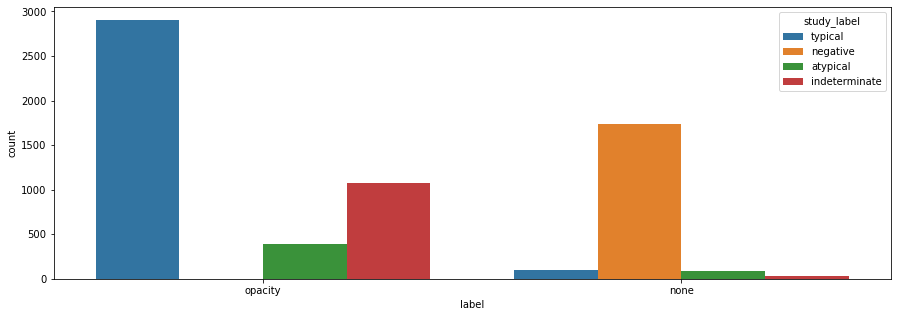

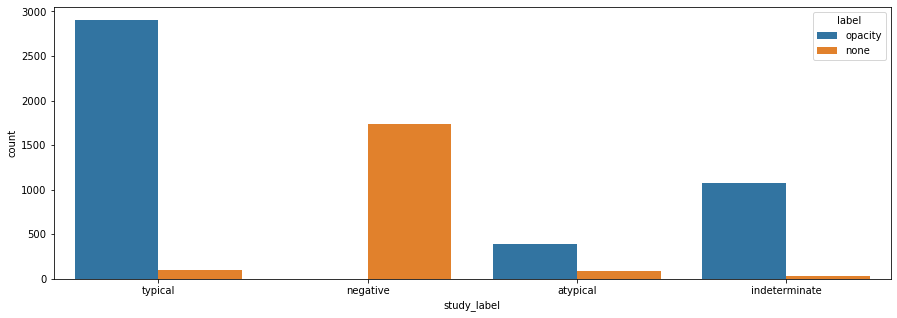

In [9]:
plt.figure(figsize=(15, 5))
sns.countplot(x="label", hue="study_label", data=df)
plt.show()

plt.figure(figsize=(15, 5))
sns.countplot(x="study_label", hue="label", data=df)
plt.show()

### Dataset

In [10]:
transforms = get_transfos_det(augment=True, visualize=True, bbox_format="yolo")

In [11]:
dataset = CovidDetDataset(df, DATA_PATH + f"train_{SIZE}/", bbox_format="yolo", transforms=transforms)

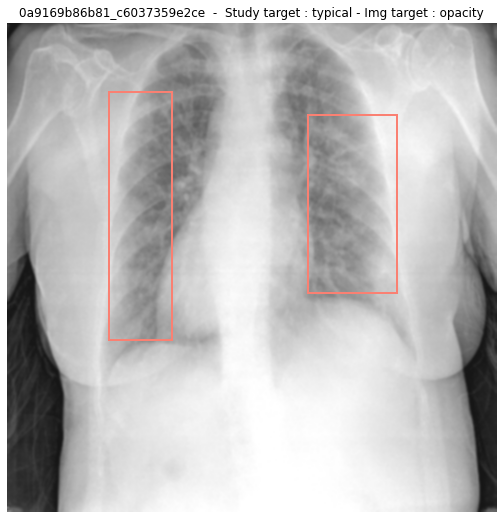

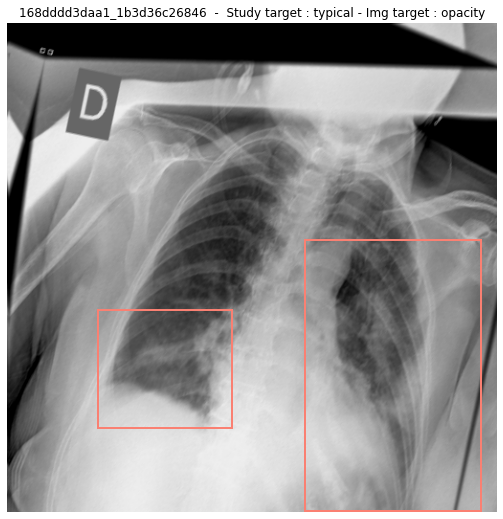

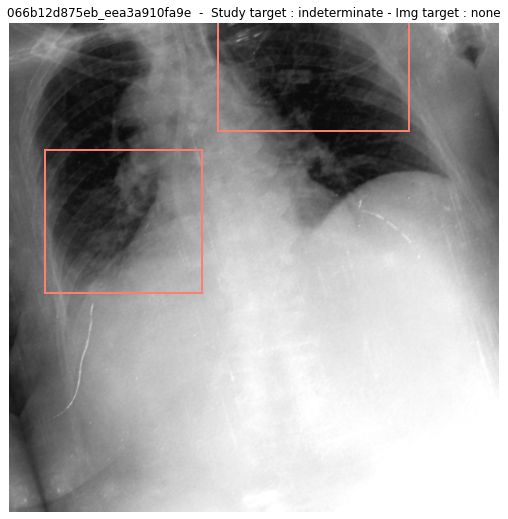

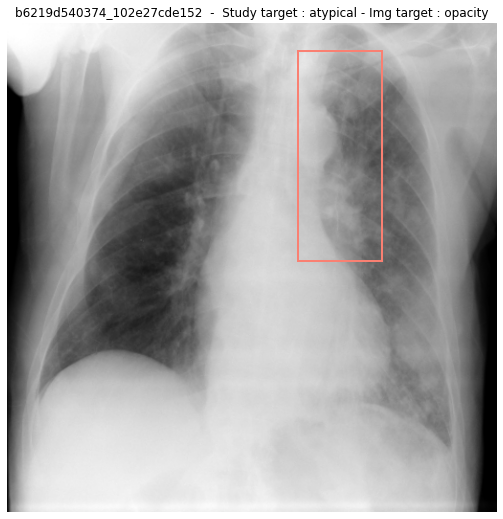

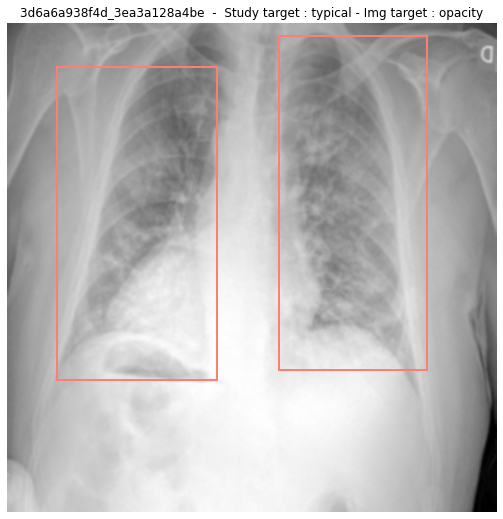

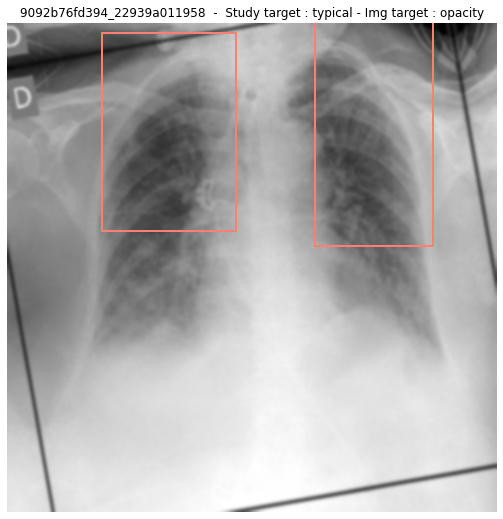

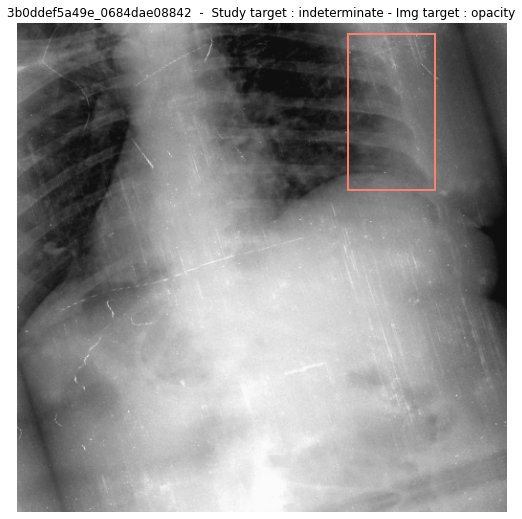

In [12]:
for i in np.random.choice(len(dataset), 10):
    img, mask, y, y_img, boxes = dataset[i]
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1, 2, 0)
        mask = mask.cpu().numpy()[:, :, None]

    if len(boxes):
        plt.figure(figsize=(9, 9))
        plot_sample(img, boxes, bbox_format="yolo")
#         plot_sample(mask, boxes, bbox_format="yolo")
        plt.title(
            f'{df["save_name"][i][:-4]}  -  Study target : {CLASSES[int(y)]} - '
            f'Img target : {CLASSES_IMG[int(y_img)]}'
        )

## Model

In [13]:
model = get_model('resnet18', reduce_stride=True, num_classes=4)

Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0


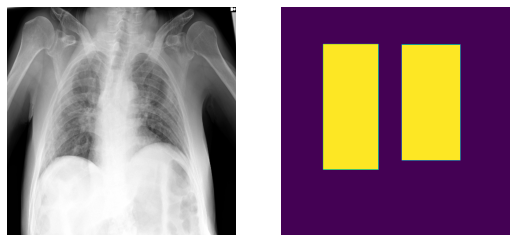

In [14]:
transforms = get_transfos_cls(augment=False, visualize=True)
dataset = CovidClsDataset(df, DATA_PATH + f"train_{SIZE}/", transforms=transforms)

x, m, y, y_img = dataset[0]

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.imshow(x.cpu().numpy().transpose(1, 2, 0))
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(m.cpu().numpy()[:, :, None])
plt.axis(False)

x = x.unsqueeze(0).float()
m = m.unsqueeze(0).float()
y = y.unsqueeze(0)
y_img = y_img.unsqueeze(0)

In [15]:
pred = model(x)

In [16]:
for p in pred:
    try:
        print(p.size())
    except:
        for p_ in p:
            print(' ', p_.size())

torch.Size([1, 4])
torch.Size([1, 1])
  torch.Size([1, 1, 32, 32])
  torch.Size([1, 1, 32, 32])


In [17]:
from training.optim import CovidLoss
loss = CovidLoss()

In [18]:
y, pred[0]

(tensor([1.]),
 tensor([[ 0.7552,  0.1855, -0.5663, -0.6856]], grad_fn=<AddmmBackward>))

In [19]:
loss = CovidLoss()
loss(pred[0], pred[1], pred[2], y, y_img, m)

tensor([1.8644], grad_fn=<AddBackward0>)

## Training

In [20]:
BATCH_SIZES = {
    "resnext50_32x4d": 16,
}

In [21]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    
    size = SIZE
    bbox_format = "yolo"
    root_dir = DATA_PATH + f"train_{SIZE}/"
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    k = 5
    folds_col = "kfold"
    selected_folds = [0] # , 1, 2, 3, 4]

    # Model
    selected_model = "resnext50_32x4d"  # "resnext50_32x4d"
    num_classes = len(CLASSES)
    reduce_stride = True

    # Training
    samples_per_patient = 1
    optimizer = "Adam"
    batch_size = BATCH_SIZES[selected_model]
    epochs = 20

    lr = 1e-3
    warmup_prop = 0.05
    val_bs = batch_size * 2
    
    first_epoch_eval = 0
    
    mix = "cutmix"
    mix_proba = 0.  # TODO
    mix_alpha = 5

    name = "model"

In [22]:
DEBUG = False
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f'Logging results to {log_folder}')
    save_config(Config, log_folder + 'config')
    df.to_csv(log_folder + 'data.csv', index=False)
    create_logger(directory=log_folder, name="logs.txt")
    
pred_oof_study, pred_oof_img = k_fold(
    Config,
    df, 
    df_extra=None,
    log_folder=log_folder
)

Logging results to ../logs/2021-07-24/0/

-------------   Fold 1 / 5  -------------

Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0
    -> 5065 training images
    -> 1269 validation images
    -> 66625593 trainable parameters

Using 302 out of 316 batches by limiting to 1 samples per study.

